# Are We There Yet?

Author: Fred J. Hickernell

You are visiting your friend and it will require
* A 5 minute walk to the ‘L’ station
* Waiting for the train, which arrives every 20 minutes
* Traveling 30 minutes by ‘L’
* Catching a taxi at the ‘L’ destination
  * There is a 20% chance that the car is waiting for you
  * Otherwise the average wait time is 10 minutes
* A 12 minute taxi ride 

_How long should you plan for the trip to take?_

#### Some LaTeX macros (hidden in math mode, will not render correctly in VS Code)
$
\newcommand{\vh}{\boldsymbol{h}}
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\newcommand{\Prob}{\mathbb{P}}
\newcommand{\bbone}{\mathbb{1}}
\newcommand{\disc}{\operatorname{disc}}
\newcommand{\norm}[2]{{\left \lVert #1 \right \rVert}_{#2}}
$

#### Run this notebook in Juypter with the `conda qmcpy` environment or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/QMCSoftware/MATH565Fall2025/blob/main/notebooks/AreWeThereYet.ipynb?flush_cache=true)

In [1]:
if "google.colab" in str(get_ipython()):
    print("⚡Note: Setup here can take a few minutes.")
    !apt-get -y install cm-super dvipng texlive-latex-extra texlive-latex-recommended
    !pip install git+https://github.com/QMCSoftware/QMCSoftware.git@develop
    !git clone https://github.com/QMCSoftware/MATH565Fall2025.git
    %cd MATH565Fall2025/notebooks
    print("\n✅ Colab setup complete.")
    print("   For faster performance, please install the qmcpy environment locally.")

## Mathematical set-up
$$
\begin{aligned}
T & = \text{travel time} = 5 + W_1 + 30 + W_2 + 12 = 47 + W_1 + W_2 \\
W_1 & = \text{waiting time for 'L' train} \sim \mathcal{U}[0,20] \\
W_2 & = \text{waiting time for taxi}, \quad 
\Prob(W_2 \le w) = \begin{cases} 0, & w < 0 \\ 0.2+ 0.04 \exp(-w/20), & w \ge 0 \end{cases}
\end{aligned}
$$

We assume that $W_1$ and $W_2$ are independent

We will now perform Monte Carlo simulation


## Monte Carlo estimation of the average waiting time

### Import needed packages and initialize some parameters

In [2]:
import matplotlib.pyplot as plt
import math, time, timeit, sys
import numpy as np
import scipy as sp
from scipy import stats
import qmcpy as qp
import sympy as sy
from IPython.display import Markdown
import mc_class as init
init.init()                 # apply rcParams + numpy error policy
colors = init.get_py_colors()

### Set up random variables $W_1$ and $W_2$

In [4]:
# --- Parameters --- We define these with variables so that we can change their values later
walk_time = 5  #time to walk to the 'L'  You can experiment by chaning these
on_L_time = 30  #time on the 'L'
taxi_time = 12  #time in the taxi
T0 = walk_time + on_L_time + taxi_time # fixed time
wait_L_time = 20  #max time until next 'L' train
taxi_now = 0.2  #probability of taxi now
taxi_wait_avg = 10  #average time to wait for a taxi if it is not there


# --- W1: Uniform(0, L_time) ---
W1 = stats.uniform(loc=0, scale=wait_L_time)  #this is the waiting time for the 'L'

# --- W2: Zero-inflated Exponential ---
# Since scipy does not have a zero-inflated exponential we define it with the help of ChatGPT
#   This involves defining the CDF, PPF, mean and standard deviation
from scipy import stats

class zero_inflated_expon(stats.rv_continuous):
    """
    Zero-inflated exponential:
    P(X=0) = p_zero;  for x>0, X|X>0 ~ Exponential(rate) with mean = 1/rate.

    Parameters
    ----------
    p_zero : float in [0,1)
        Probability of zero wait time (atom at 0).
    rate : float > 0
        Exponential rate for the positive part (1/mean of positive waits).
    """
    def __init__(self, p_zero=0.2, rate=0.1, *args, **kwargs):
        super().__init__(a=0.0, name="zero_inflated_expon", *args, **kwargs)
        if not (0.0 <= p_zero < 1.0):
            raise ValueError("p_zero must be in [0,1).")
        if rate <= 0:
            raise ValueError("rate must be > 0.")
        self.p_zero = float(p_zero)
        self.rate = float(rate)

    # Public CDF (right-continuous): F(0) = p_zero
    def cdf(self, x, *args, **kwargs):
        p0, lam = self.p_zero, self.rate
        x = np.asarray(x, dtype=float)
        # For x < 0: 0; for x >= 0: p0 + (1-p0)*(1 - e^{-lam x})
        return np.where(x < 0.0, 0.0, p0 + (1.0 - p0) * (1.0 - np.exp(-lam * x)))

    # Closed-form PPF (quantile)
    def _ppf(self, q):
        p0, lam = self.p_zero, self.rate
        q = np.asarray(q, dtype=float)
        out = np.zeros_like(q)
        mask = (q > p0) & (q < 1.0)
        t = (q[mask] - p0) / (1.0 - p0)
        out[mask] = -np.log1p(-t) / lam
        out = np.where(q >= 1.0, np.inf, out)
        out = np.where(q < 0.0, np.nan, out)
        return out

    # Vectorized RNG compatible with SciPy’s machinery
    def _rvs(self, size=None, random_state=None):
        p0, lam = self.p_zero, self.rate
        u = random_state.random(size)
        x = np.zeros(size, dtype=float)
        mask = u >= p0
        x[mask] = random_state.exponential(scale=1.0/lam, size=np.sum(mask))
        return x

# --- Convenience constructor ---
def make_zie(p_zero: float, mean_pos: float):
    """
    Convenience constructor: return a zero_inflated_expon
    with atom at 0 (prob = p_zero) and mean wait time = mean_pos for positive values.
    """
    return zero_inflated_expon(p_zero=p_zero, rate=1.0/mean_pos)

# Set the parameters for our taxi waiting time
W2 = make_zie(p_zero=taxi_now, mean_pos = taxi_wait_avg)  #the rate is one over the mean

### Compute the true (population) mean travel time

In [5]:
true_mean_T = T0 + W1.mean() + W2.mean()  #use the mean properties of the random variables
                                            #in this case the answer is simple
print(f"Mean travel time = \u03bc ={true_mean_T : .1f}")

Mean travel time = μ = 65.0


### Generate random samples and compute the sample mean travel time

Here we generate independent and identically distributed (IID) samples of $W_1$ and then $W_2$ and then combine them to get samples of the total travel time

In [6]:
#This complicated code is so that we can change parameters and they will display correctly 
display(Markdown(fr"""
\begin{{gather}}
W_{{11}}, W_{{21}}, \ldots \overset{{\text{{IID}}}}{{\sim}} \mathcal{{U}}[0,{wait_L_time}] \\
W_{{12}}, W_{{22}}, \ldots \overset{{\text{{IID}}}}{{\sim}} \text{{zero inflated exponential}} \\
T_{{i}} = {T0} + W_{{i1}} + W_{{i2}}, \quad i=1,2,\ldots
\end{{gather}}
"""))


\begin{gather}
W_{11}, W_{21}, \ldots \overset{\text{IID}}{\sim} \mathcal{U}[0,20] \\
W_{12}, W_{22}, \ldots \overset{\text{IID}}{\sim} \text{zero inflated exponential} \\
T_{i} = 47 + W_{i1} + W_{i2}, \quad i=1,2,\ldots
\end{gather}


and then compute the **sample** mean

$$
\widehat{{\mu}}_n = \frac 1n \sum_{{i=1}}^n T_i,\quad n=1,2,\ldots
$$

'L' waiting time W1 samples =  [ 2.4935823   7.91991468  2.31668846 16.95749942 17.34473746 14.23149616
  9.18358174 10.25569327 18.71441592  8.18820751 11.4901525  17.67076773
 12.52769831  0.1226311  14.48987509 16.87301533  9.01503946  7.26204173
 15.69587276  2.15599863]
Taxi waiting time W2 samples =  [27.24906592 23.5894333   0.         18.6280672  12.35793315 16.39507798
  2.66198672 14.03100145  0.84291716 25.23029433  9.96782521  0.
  3.49154986  1.20240416 21.48325574  9.51594023  3.66670201  7.65304546
  0.          0.        ]


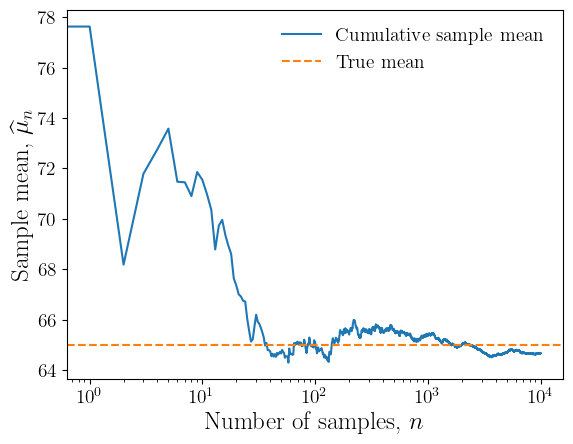

In [7]:
n_max = 10**4  #sample size
nrange = np.arange(1, n_max+1)
W1_samples =  W1.rvs(size=n_max)  #generate samples of waiting times for the 'L'
W2_samples =  W2.rvs(size=n_max)  #generate samples of waiting times for the taxi
print("'L' waiting time W1 samples = ",W1_samples[:20])
print("Taxi waiting time W2 samples = ",W2_samples[:20])
T_samples = T0 + W1_samples + W2_samples  #generate samples of total travel time
sample_mean_T = np.cumsum(T_samples) / nrange  #compute the travel time sample means for first 1, 2, ..., n samples

plt.semilogx(sample_mean_T, label="Cumulative sample mean")
plt.axhline(true_mean_T, color=colors["orange"], linestyle='--', label="True mean")
plt.xlabel(r"Number of samples, $n$")
plt.ylabel(r"Sample mean, $\widehat{\mu}_n$")
plt.legend();  #add a semi-colon to suppress output saying that there was a plot

<div class="highlight-note">
<h4>Do you notice that</h4>
<ul>
  <li>The sample mean converges to the true (population) mean</li>
  <li>The convergence is not monotonic, but oscillatory</li>
  <li>Each time that you run the cell above the output changes</li>
</ul>
</div>

## What is the convergence rate?

Now let's repeat this experiment $R$ times and look at the average convergence. Notice that the error tends to zero at a rate of $\mathcal{O}(n^{-1/2})$.  For $r =  1, 2, \ldots, R$

In [8]:
#Complicated code to allow printing of parameters if they are reset
display(Markdown(fr"""
\begin{{gather}}
W_{{11}}^{{(r)}}, W^{{(r)}}_{{21}}, \ldots \overset{{\text{{IID}}}}{{\sim}} \mathcal{{U}}[0,{wait_L_time}] \\
W_{{12}}^{{(r)}}, W_{{22}}^{{(r)}}, \ldots \overset{{\text{{IID}}}}{{\sim}} \text{{zero inflated exponential}} \\
T_{{i}}^{{(r)}} = {T0} + W_{{i1}}^{{(r)}} + W_{{i2}}^{{(r)}}. \quad i=1, 2 \ldots 
\end{{gather}}
"""))


\begin{gather}
W_{11}^{(r)}, W^{(r)}_{21}, \ldots \overset{\text{IID}}{\sim} \mathcal{U}[0,20] \\
W_{12}^{(r)}, W_{22}^{(r)}, \ldots \overset{\text{IID}}{\sim} \text{zero inflated exponential} \\
T_{i}^{(r)} = 47 + W_{i1}^{(r)} + W_{i2}^{(r)}. \quad i=1, 2 \ldots 
\end{gather}


and then compute the **sample** mean
$$
\widehat{\mu}_n^{(r)} = \frac 1n \sum_{i=1}^n T_i^{(r)}, \quad n = 1, 2, \ldots
$$

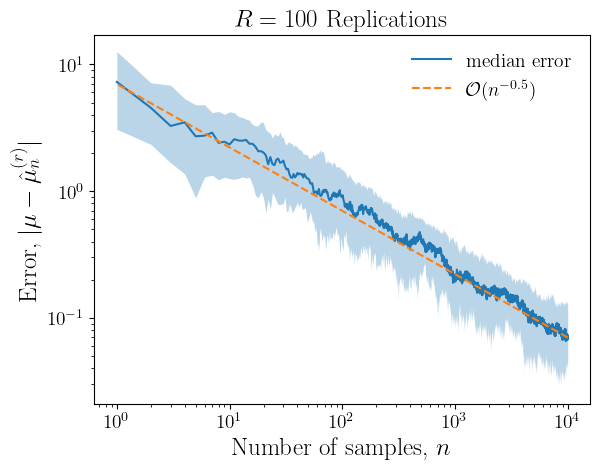

In [9]:
R = 100 #number of replications
W1_R_samples = W1.rvs(size=(n_max,R))  #generate R replications of samples of waiting times for the 'L'
W2_R_samples = W2.rvs(size=(n_max,R))  #generate R replications of samples of waiting times for the taxi
T_R_samples = T0 + W1_R_samples + W2_R_samples  #generate N replications of samples of total travel time
sample_mean_T_R_reps = np.cumsum(T_R_samples, axis = 0) / nrange[:, None]   #compute the travel time sample means for all N replications
error_sample_mean_T = np.abs(true_mean_T - sample_mean_T_R_reps)  #errors
bot_per = 25
top_per = 75
err_bot = np.percentile(error_sample_mean_T, bot_per, axis=1)
err_med = np.percentile(error_sample_mean_T, 50, axis=1)
err_top = np.percentile(error_sample_mean_T, top_per, axis=1)
fig, ax = plt.subplots()
ax.loglog(nrange,err_med, '-', color = colors["blue"], label="median error")
ax.fill_between(nrange, err_bot, err_top, color = colors["blue"],alpha = 0.3, linewidth = 0)
init.plot_rate_line(ax, nrange[[-1,0]], y_start=err_med[-1], rate=0.5, color=colors["orange"])
ax.set_xlabel(r"Number of samples, $n$")
ax.set_ylabel(r"Error, $| \mu - \hat{\mu}^{(r)}_n |$")
ax.set_title(f"$R = {R}$ Replications")
plt.legend(frameon=False);

### Root mean squared error

We know that the sample mean, $\widehat{\mu}_n$ has variance $\sigma^2/n$, where $\sigma^2$ is the variance of $T$.  Since $T$ is a sum of independent random variables, we can compute its variance

In [10]:
true_var_T = W1.var() + W2.var()  #the variance of a sum of independent variables is the sum of the variances
true_std_T = np.sqrt(true_var_T)
print(f"Variance of waiting time for 'L' = {W1.var() : .1f} or standard deviation of {W1.std() : .1f}")
print(f"Variance of waiting time for taxi = {W2.var() : .1f} or standard deviation of {W2.std() : .1f}")
print(f"Variance of travel time = \u03C3\u00B2 ={true_var_T : .1f} or standard deviation of \u03C3 ={true_std_T : .1f}")

Variance of waiting time for 'L' =  33.3 or standard deviation of  5.8
Variance of waiting time for taxi =  96.0 or standard deviation of  9.8
Variance of travel time = σ² = 129.3 or standard deviation of σ = 11.4


### Central Limit Theorem (CLT)

For large $n$, $\widehat{\mu}_n$ is approximately distributed $\mathcal{N}(\mu,\sigma^2/n)$ and so for approximately 
* 25% of the replications, the _absolute error_ would be below the 62.5% percentile of the standard normal times $\sigma/\sqrt{n}$
* 50% of the replications, the _absolute error_ would be below the 75% percentile of the standard normal times $\sigma/\sqrt{n}$
* 75% of the replications, the _absolute error_ would be below the 87.5% percentile of the standard normal times $\sigma/\sqrt{n}$

The plot below shows which parts of the normal distribution contribute to the middle half of the absolute error

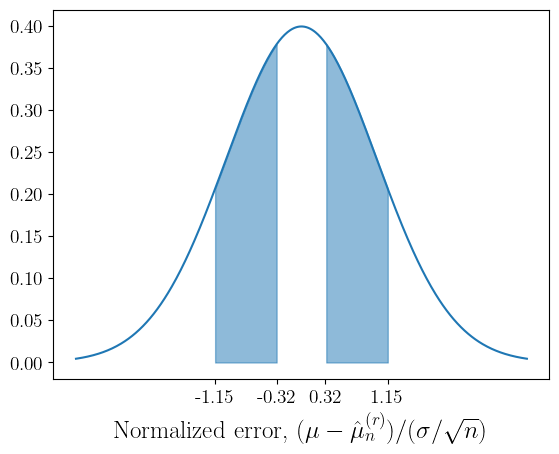

In [11]:
x = np.linspace(-3, 3, 500)
pdf = stats.norm.pdf(x) # Standard normal distribution
q1, q2, q3, q4 = stats.norm.ppf(0.125), stats.norm.ppf(0.375), stats.norm.ppf(0.625), stats.norm.ppf(0.875) # Quantiles
plt.plot(x, pdf, color = colors["blue"])  # Plot density

# Shade between q1 and q2 and between between q3 and q4
mask1 = (x >= q1) & (x <= q2)
plt.fill_between(x[mask1], 0, pdf[mask1], color=colors["blue"], alpha=0.5)
mask2 = (x >= q3) & (x <= q4)
plt.fill_between(x[mask2], 0, pdf[mask2], color=colors["blue"], alpha=0.5)
plt.xticks(ticks=[q1, q2, q3, q4],
            labels=[f"{q1:.2f}", f"{q2:.2f}", f"{q3:.2f}", f"{q4:.2f}"])
plt.xlabel(r"Normalized error, $(\mu - \hat{\mu}^{(r)}_n)/(\sigma/\sqrt{n})$")
plt.show()

The plot below shows how well the absolute error tracks with the CLT prediction

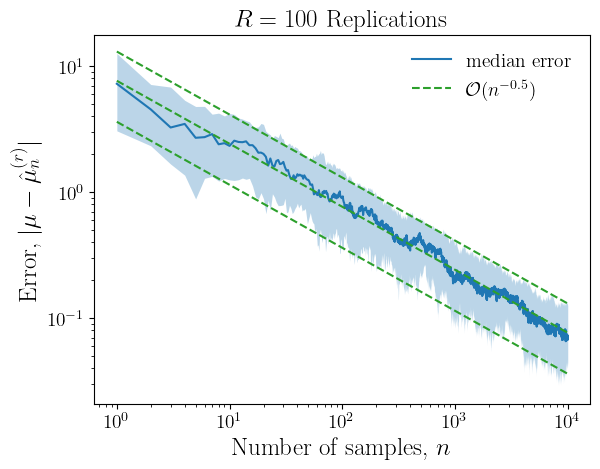

In [12]:
fig, ax = plt.subplots()
ax.loglog(nrange,err_med, '-', color = colors["blue"], label="median error")
ax.fill_between(nrange, err_bot, err_top, color = colors["blue"],alpha = 0.3, linewidth = 0)
init.plot_rate_line(ax, nrange[[0,-1]], y_start=true_std_T*stats.norm.ppf(0.75), rate=0.5, color=colors["green"])  #plotting rate lines for median
init.plot_rate_line(ax, nrange[[0,-1]], y_start=true_std_T*q3, rate=0.5, color=colors["green"], label="")  #and the middle half
init.plot_rate_line(ax, nrange[[0,-1]], y_start=true_std_T*q4, rate=0.5, color=colors["green"], label="")
ax.set_xlabel(r"Number of samples, $n$")
ax.set_ylabel(r"Error, $| \mu - \hat{\mu}^{(r)}_n |$")
ax.set_title(f"$R = {R}$ Replications")
plt.legend(frameon=False);

## What if we do not know the standard deviation
For realistic examples where we do not know the standard deviation, we can construct an approximate confidence interval



In [13]:
#First we estimate the standard deviation
confid_level = 0.99
q_confid = - stats.norm.ppf((1-confid_level)/2.)
n_sig = 100  #pilot sample size
fudge = 1.2  #inflation or fudge factor
W1_sig_samples =  W1.rvs(size=n_sig)  #generate samples of waiting times for the 'L'
W2_sig_samples =  W2.rvs(size=n_sig)  #generate samples of waiting times for the taxi
T_sig_samples = 47 + W1_sig_samples + W2_sig_samples  #generate samples of total travel time
sample_std_T = np.std(T_sig_samples)

#Next we estimate the mean with an independent set of samples
n_mean = 10000  #sample size to estimate mean
W1_mean_samples =  W1.rvs(size=n_mean)  #generate samples of waiting times for the 'L'
W2_mean_samples =  W2.rvs(size=n_mean)  #generate samples of waiting times for the taxi
T_mean_samples = 47 + W1_mean_samples + W2_mean_samples  #generate samples of total travel time
sample_mean_T = np.mean(T_mean_samples)  #compute the travel time sample means for first 1, 2, ..., n samples
confid_interval = sample_mean_T + np.array([-1,1])*(q_confid*fudge*sample_std_T)/np.sqrt(n_mean)
print(f"The mean travel time is within the interval [{confid_interval[0]:.1f},{confid_interval[1]:.1f}] with probability about {100*confid_level:.1f}%")

The mean travel time is within the interval [64.6,65.3] with probability about 99.0%


## What about percentiles or quantiles
You may be more interested in the _90% largest_ travel time, to reduce the chance of arriving late.  This can be calculated analytically for this simple case, but we can also illustrate Monte Carlo using the sample quantile function.

In [14]:
prob = 0.9  #the quantile value we are interested in
sample_quantiles_T_R_reps = np.quantile(T_R_samples, prob, axis=0)
mean_sample_quantiles = sample_quantiles_T_R_reps.mean()
print(f"With probability{prob*100 : 0.1f}% you will make it to your friend's house within{mean_sample_quantiles : 0.1f} minutes")

With probability 90.0% you will make it to your friend's house within 79.4 minutes


## Conditional Monte Carlo
When the function defining the random variable of interest is not a black box, but a gray box, then we may see performance gains from _conditional Monte Carlo_.  For this example, we have 


In [15]:
#Complicated code to allow printing of parameters if they are reset
display(Markdown(fr"""
\begin{{gather}}
W_{{1}} \overset{{\text{{IID}}}}{{\sim}} \mathcal{{U}}[0,{wait_L_time}], \qquad 
W_{{2}} \overset{{\text{{IID}}}}{{\sim}} \text{{zero inflated exponential}}, \qquad
T = {T0} + W_{{1}} + W_{{2}}\\
T \mid W_{{2}} \sim \mathcal{{U}}[{T0}+W_2,{T0}+W_2 + {wait_L_time}] \\
\Ex(T) =  \Ex_{{W_{{2}}}}[\Ex_{{W_{{1}}}}(T | W_{{2}})], \quad \text{{where }} \Ex_{{W_{{1}}}}(T | W_{{2}}) = {T0 + wait_L_time/2.} + W_{{2}} \\
\varrho_T(t) = \Ex_{{W_{{2}}}} \bigl \{{ \text{{density at $t$ of }}\mathcal{{U}}[{T0}+W_2,{T0+wait_L_time}+W_2] \bigr \}}  
 = \Ex_{{W_{{2}}}} \bigl [ \bbone_{{[{T0} + W_2 , {T0+wait_L_time}+W_2]}} (t)/{wait_L_time} \bigr] =  \Ex_{{W_{{2}}}} \bigl [ \bbone_{{[t - {T0+wait_L_time}, t - {T0}]}} (W_2)/{wait_L_time} \bigr]
\end{{gather}}
"""))


\begin{gather}
W_{1} \overset{\text{IID}}{\sim} \mathcal{U}[0,20], \qquad 
W_{2} \overset{\text{IID}}{\sim} \text{zero inflated exponential}, \qquad
T = 47 + W_{1} + W_{2}\\
T \mid W_{2} \sim \mathcal{U}[47+W_2,47+W_2 + 20] \\
\Ex(T) =  \Ex_{W_{2}}[\Ex_{W_{1}}(T | W_{2})], \quad \text{where } \Ex_{W_{1}}(T | W_{2}) = 57.0 + W_{2} \\
\varrho_T(t) = \Ex_{W_{2}} \bigl \{ \text{density at $t$ of }\mathcal{U}[47+W_2,67+W_2] \bigr \}  
 = \Ex_{W_{2}} \bigl [ \bbone_{[47 + W_2 , 67+W_2]} (t)/20 \bigr] =  \Ex_{W_{2}} \bigl [ \bbone_{[t - 67, t - 47]} (W_2)/20 \bigr]
\end{gather}


First we plot the error of estimating $\Ex_{W_2}[\Ex_{W_1}(T | W_2)]$ by Monte Carlo

The standard deviation of conditional expectation = 9.80
     whereas the standard deviation of travel time =  11.37


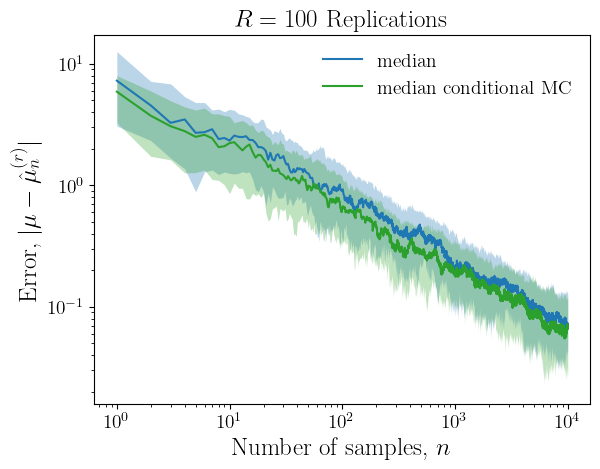

In [16]:
cond_T_R_reps = T0 + wait_L_time/2 + W2_R_samples  #replicated samples of conditional expectation of T given W_2 = w2
print(f"The standard deviation of conditional expectation = {W2.std() :.2f}\n" \
     f"     whereas the standard deviation of travel time = {true_std_T : .2f}" )
sample_mean_cond_T_R_reps = np.cumsum(cond_T_R_reps, axis = 0) / nrange[:, None]  #compute the sample mean
err_sample_mean_cond_T_R_reps = np.abs(true_mean_T - sample_mean_cond_T_R_reps)  #errors
err_bot_cond = np.percentile(err_sample_mean_cond_T_R_reps, bot_per, axis=1)
err_med_cond = np.percentile(err_sample_mean_cond_T_R_reps, 50, axis=1)
err_top_cond = np.percentile(err_sample_mean_cond_T_R_reps, top_per, axis=1)
fig, ax = plt.subplots()
ax.loglog(nrange,err_med, '-', color = colors["blue"], label="median")
ax.fill_between(nrange, err_bot, err_top, color = colors["blue"],alpha = 0.3, linewidth = 0)
ax.loglog(nrange,err_med_cond, '-', color = colors["green"], label="median conditional MC")
ax.fill_between(nrange, err_bot_cond, err_top_cond, color = colors["green"],alpha = 0.3, linewidth = 0)
ax.set_xlabel(r"Number of samples, $n$")
ax.set_ylabel(r"Error, $| \mu - \hat{\mu}^{(r)}_n |$")
ax.set_title(f"$R = {R}$ Replications")
plt.legend(frameon=False);

There is not a great improvement in the convergence because the standard deviation of the random variable whosemean we are estimating does not decrease much.

Next, we estimate the probability density of the travel time by conditional Monte Carlo

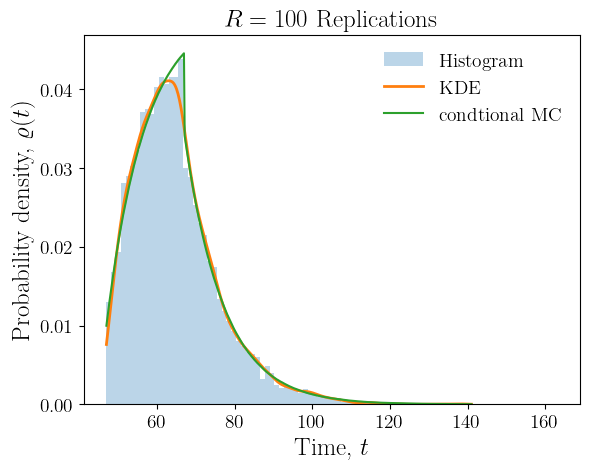

In [17]:
#This is conditional Monte Carlo to estimate the density
Tplot = np.linspace(T0, 3*T0, 500)
Tplot_min_T0 = Tplot.reshape(1,1,-1) - T0
sample_mean_rho_T_R_reps = np.mean((W2_R_samples[:,:,None] >= Tplot_min_T0 - wait_L_time) & \
                                   (W2_R_samples[:,:,None] <= Tplot_min_T0), axis = 0)/wait_L_time 
rho_bot_cond = np.percentile(sample_mean_rho_T_R_reps, bot_per, axis=0)
rho_med_cond = np.percentile(sample_mean_rho_T_R_reps, 50, axis=0)
rho_top_cond = np.percentile(sample_mean_rho_T_R_reps, top_per, axis=0)

#This is the kernel density estimator
rho_kde = stats.gaussian_kde(T_samples)
rho_kde_plot = rho_kde(Tplot)

#Now we plot these plus the histogram
fig, ax = plt.subplots()
ax.hist(T_samples, bins="auto", density=True, alpha=0.3, label="Histogram")  #histogram to estimate the probability density
plt.plot(Tplot,rho_kde_plot, label="KDE", linewidth=2)
ax.plot(Tplot,rho_med_cond, '-', color = colors["green"], label="condtional MC")
ax.fill_between(Tplot, rho_bot_cond, rho_top_cond, color = colors["green"],alpha = 0.3, linewidth = 0)
ax.set_xlabel(r"Time, $t$")
ax.set_ylabel(r"Probability density, $\varrho(t)$")
ax.set_title(f"$R = {R}$ Replications")
plt.legend(frameon=False);

<div class="highlight-note">
Note:
<ul>
  <li>The <em>histogram</em> is a rough estimate of the probability density</li>
  <li>The <em>kernel density estimator</em> is a smoother estimate of the probability density, but perhaps too smooth</li>
  <li>The <em>conditional Monte Carlo estimator</em> is the most accurate estimate probability density, and in fact the whole middle range of estimates are indistinguishable to the eye</li>
</ul></div>

## Another kind of sampling

* The examples above use independent and identically distributed (IID) sampling.
* There is another kind of sampling called low discrepancy (LD) sampling that give faster convergence.  Discrepancy is a measure of how much different the empirical distribution is from the target (usually continuous) distribution.

Here is an example.

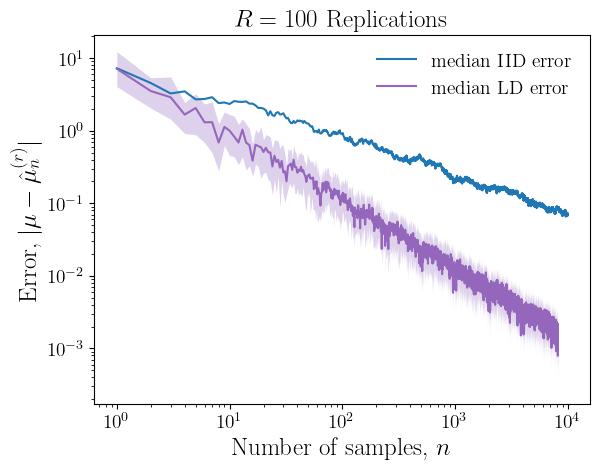

In [18]:
n_LD_max = 2**13  #must be a power of 2
n_LD_range = np.arange(1, n_LD_max+1)
LD_X_R_samples = qp.Sobol(dimension=2,replications=R).gen_samples(n_LD_max)
W1_LD_R_samples = W1.ppf(LD_X_R_samples[:,:,0])  #generate R replications of samples of waiting times for the 'L'
W2_LD_R_samples = W2.ppf(LD_X_R_samples[:,:,1])  #generate R replications of samples of waiting times for the taxi
T_LD_R_samples = 47 + W1_LD_R_samples + W2_LD_R_samples  #generate N replications of samples of total travel time
sample_mean_T_LD_R_reps = np.cumsum(T_LD_R_samples, axis = 1) / n_LD_range   #compute the travel time sample means for all N replications
error_sample_mean_T_LD = np.abs(true_mean_T - sample_mean_T_LD_R_reps)  #errors
err_LD_bot = np.percentile(error_sample_mean_T_LD, bot_per, axis=0)
err_LD_med = np.percentile(error_sample_mean_T_LD, 50, axis=0)
err_LD_top = np.percentile(error_sample_mean_T_LD, top_per, axis=0)
fig, ax = plt.subplots()
ax.loglog(nrange,err_med, '-', color = colors["blue"], label="median IID error")
ax.loglog(n_LD_range,err_LD_med, '-', color = colors["purple"], label="median LD error")
ax.fill_between(n_LD_range, err_LD_bot, err_LD_top, color = colors["purple"],alpha = 0.3, linewidth = 0)
ax.set_xlabel(r"Number of samples, $n$")
ax.set_ylabel(r"Error, $| \mu - \hat{\mu}^{(r)}_n |$")
ax.set_title(f"$R = {R}$ Replications")
plt.legend(frameon=False);

#### Notice the faster convergence. This is a teaser for later in the course.

We can begin to see why by plotting IID and LD wait times.  Note that LD has fewer gaps and clusters

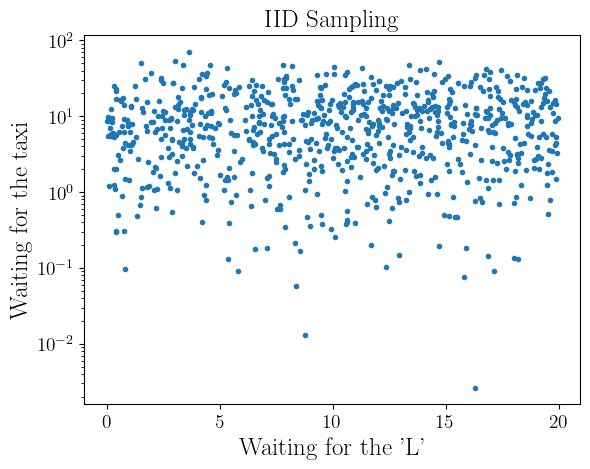

In [19]:
#First the IID sampling
plt.semilogy(W1_samples[:1000],W2_samples[:1000],'.')
plt.xlabel("Waiting for the 'L'")
plt.ylabel("Waiting for the taxi")
plt.title("IID Sampling");

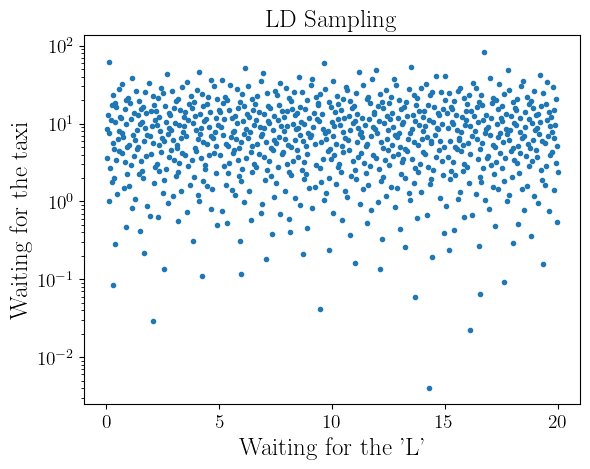

In [20]:
#Next the LD sampling
plt.semilogy(W1_LD_R_samples[0,:1000],W2_LD_R_samples[0,:1000],'.')
plt.xlabel("Waiting for the 'L'")
plt.ylabel("Waiting for the taxi")
plt.title("LD Sampling");

<div class="highlight-note">
As an aside,  my original code for the simulation using LD sequences was quite slow.  It happened to be because the zero-inflated exponential random variable class that ChatGPT created for me had <em>no quantile function</em>.  The quantile function is needed to transform the uniform LD sequences to the desired distribution.  When I asked ChatGPT to rectify that omission, the speed improved by orders of magnitude.
</div>